## Dataset Formation

In [3]:
import pandas as pd
import ast
import numpy as np
from glob import glob
import os
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from features import compute_features

In [5]:

files = glob('recordings/*.txt')

for file in files:
    
    new_filename = file.replace('.txt', '_features.csv').replace("recordings", "train_data")
    if os.path.exists(new_filename): continue
        
    events = []
    monitors = []
    with open(file, 'r') as f:
        monitors.append(ast.literal_eval(f.readline().strip()))
        for line in f:
            event = ast.literal_eval(line.strip())
            events.append(event)

    # Convert events to a list of dictionaries
    width, height = monitors[0][1], monitors[0][2]
    event_list = []
    for event in events:
        if event[0] == 'move':
            event_dict = {'event_type': 'move', 'time': event[1], 'x': event[2]/width, 'y': event[3]/height}
        elif event[0] == 'click':
            event_dict = {'event_type': 'click', 'time': event[1], 'x': event[2]/width, 'y': event[3]/height,
                        'button': event[4], 'pressed': event[5]}
        elif event[0] == 'scroll':
            event_dict = {'event_type': 'scroll', 'time': event[1], 'x': event[2]/width, 'y': event[3]/height,
                        'dx': event[4], 'dy': event[5]}
        else:
            continue
        event_list.append(event_dict)

    # Convert to DataFrame and sort by time
    df = pd.DataFrame(event_list, columns=['event_type', 'time', 'x', 'y', 'button', 'pressed', 'dx', 'dy'])
    df = df.sort_values('time').reset_index(drop=True)

    # Step 2: Organize events into time windows
    start_time = df['time'].min()
    df['timestamp'] = ((df['time'] - start_time) // 0.1).astype(int)
    
    unique_timestamps = df['timestamp'].unique()
    blank_timestamps = [i for i in range(unique_timestamps.min(), unique_timestamps.max() + 1) if i not in unique_timestamps]
    
    # insert blank rows for missing timestamps
    new_rows = []
    for ts in blank_timestamps:
        new_rows.append({'timestamp': ts})
    df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
    df = df.sort_values('timestamp').reset_index(drop=True).fillna(0)
    

    # Step 3: Extract features for each time window
    # Apply the feature extraction function to each time window
    features_df = df.groupby('timestamp').apply(compute_features, include_groups=False).reset_index(drop=True)
    
    features_df.to_csv(file.replace('.txt', '_features.csv').replace("recordings", "train_data"), index=False)
    print(f"Features saved to {file.replace('.txt', '_features.csv')}")

## Trainer

In [6]:
classification_classes = {
  "web_browsing": 0, # web
  "ppt": 1, # design tools,
  "figma": 1, # design tools
  "reading": 2, # reading papers
  "finding_mines": 3, # game
  "chess": 3, # game
  "youtube": 4, # youtube
  "chatting": 5, # chatting
}

category_names = []
for label in sorted(classification_classes.values()):
  name = ""
  for tag, l in classification_classes.items():
    if l == label:
      if name != "":
        name += "/"
      name += tag
  if not name in category_names:
    category_names.append(name)
category_names

['web_browsing',
 'ppt/figma',
 'reading',
 'finding_mines/chess',
 'youtube',
 'chatting']

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder

import joblib

In [8]:


def process_class_data(file, window_size, window_interval=5, split=0.9):
    df = pd.read_csv(file)
    df = df.ffill().bfill()
    df = df.dropna()
    
    index = int(split * df.shape[0])
    
    train_df = df.iloc[:index]
    test_df = df.iloc[index:]
    
    train_windows = []
    for i in range(0, train_df.shape[0] - window_size + 1, window_interval):
        window = train_df.iloc[i:i+window_size]
        features = window.values.flatten()
        train_windows.append(features)
    
    test_windows = []
    for i in range(0, test_df.shape[0] - window_size + 1, window_interval):
        window = test_df.iloc[i:i+window_size]
        features = window.values.flatten()
        test_windows.append(features)
        
    return train_windows, test_windows

def prepare_data(window_size=50, window_interval=5, resample=True, split=0.8):
    # Process the data for each class
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for tag, label in classification_classes.items():
        files = glob(f'train_data/{tag}_*.csv')
        for file in files:
            # print(f'Processing {file} for class {tag}')
            train_windows, test_windows = process_class_data(file, window_size, window_interval, split=split)
            X_train.extend(train_windows)
            X_test.extend(test_windows)
            y_train.extend([label] * len(train_windows))
            y_test.extend([label] * len(test_windows))

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    X_train = np.nan_to_num(X_train, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)
    X_test = np.nan_to_num(X_test, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)

    # Normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    

    # Print per-class counts
    # for label, count in zip(*np.unique(y_train, return_counts=True)):
    #     print(f'Class {label}: {count} samples')

    if resample:
        oversampler = RandomOverSampler(random_state=42)
        X_train, y_train = oversampler.fit_resample(X_train, y_train)

    # print(f'X_train shape: {X_train.shape} -> {X_resampled.shape}')
    # print(f'X_test shape: {X_test.shape}')
    return X_train, X_test, y_train, y_test, scaler

In [9]:
label_count = defaultdict(lambda: [0, 0])
for tag, label in classification_classes.items():
  files = glob(f'train_data/{tag}_*.csv')
  for file in files:
    train_windows, test_windows = process_class_data(file, 400, 5, split=0.7)
    label_count[label][0] += len(train_windows)
    label_count[label][1] += len(test_windows)
for label, (train_count, test_count) in label_count.items():
  print(f'Class {label}: {train_count} / {test_count} samples')

Class 0: 1351 / 399 samples
Class 1: 1863 / 663 samples
Class 2: 647 / 187 samples
Class 3: 2459 / 781 samples
Class 4: 1059 / 273 samples
Class 5: 249 / 61 samples


In [10]:
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier

def train(model_name, window_size, window_interval, resample=True, split=0.8):
    if model_name == 'hist_boosting':
        model = HistGradientBoostingClassifier(random_state=42)
    elif model_name == 'gradient_boosting':
        model = GradientBoostingClassifier(random_state=42, verbose=1)
    elif model_name == 'lightgbm':
        model = LGBMClassifier(random_state=42, n_jobs=-1)
    elif model_name == 'random_forest':
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
    elif model_name == 'knn':
        model = KNeighborsClassifier(n_jobs=-1)
    else:
        raise ValueError(f"Unknown MODEL: {model_name}")

    X_resampled, X_test, y_resampled, y_test, scaler = prepare_data(window_size, window_interval, resample=resample, split=split)
    
    model.fit(X_resampled, y_resampled)

    # Predict on the test set and evaluate performance
    y_pred = model.predict(X_test)
    
    return X_test, y_test, y_pred, model, scaler

In [11]:
window_interval = 2
split = 0.8

## Train all models

Model: hist_boosting, Window Size: 300, Accuracy: 0.8509575353871773, F1: 0.8483012331685406


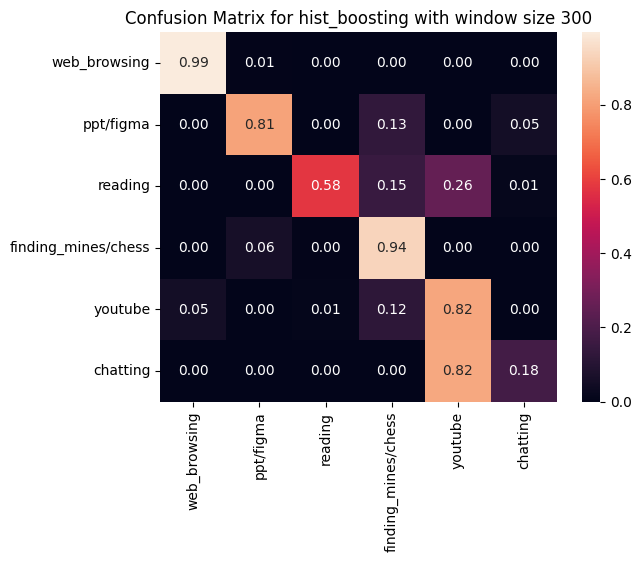

Model: hist_boosting, Window Size: 100, Accuracy: 0.7547742280920935, F1: 0.7474877755365962


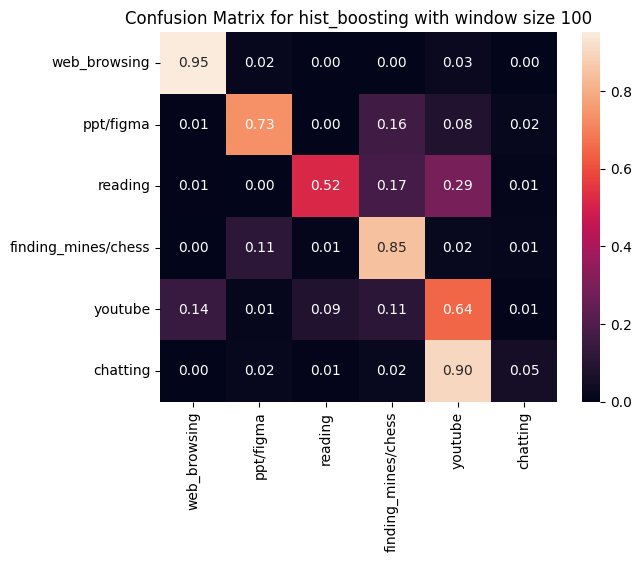

Model: hist_boosting, Window Size: 50, Accuracy: 0.6981812223496641, F1: 0.6921544915102301


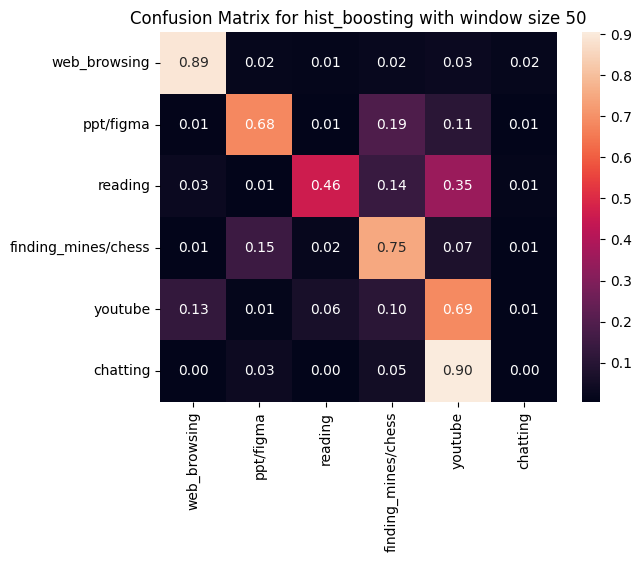

Model: random_forest, Window Size: 300, Accuracy: 0.7113516514016097, F1: 0.6983616954154775


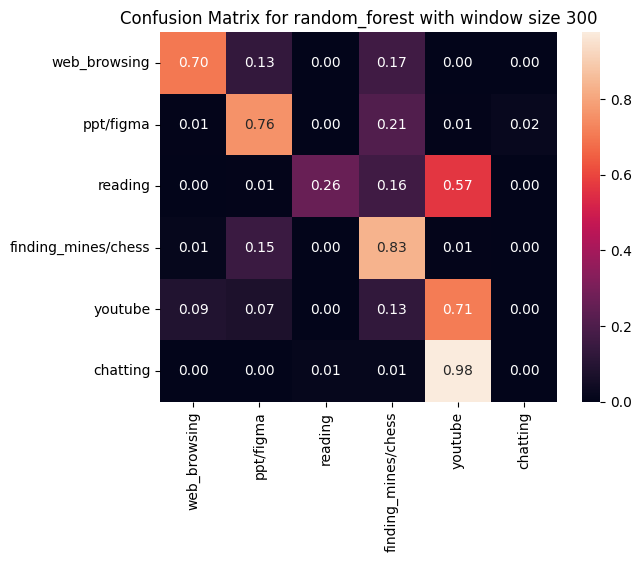

Model: random_forest, Window Size: 100, Accuracy: 0.6755309655541674, F1: 0.660790340888384


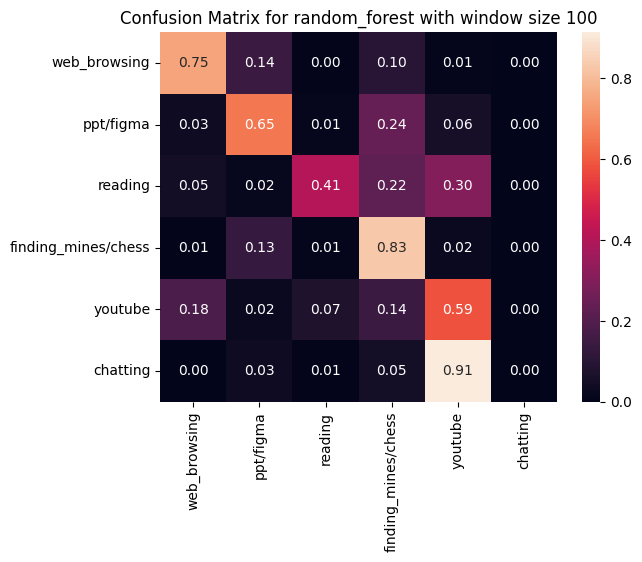

Model: random_forest, Window Size: 50, Accuracy: 0.6478780927412748, F1: 0.6355612016348441


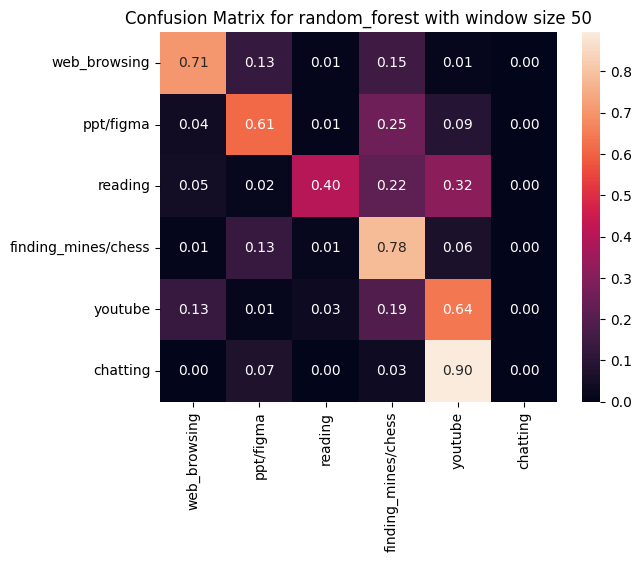

Model: knn, Window Size: 300, Accuracy: 0.2273105745212323, F1: 0.22447903248138948


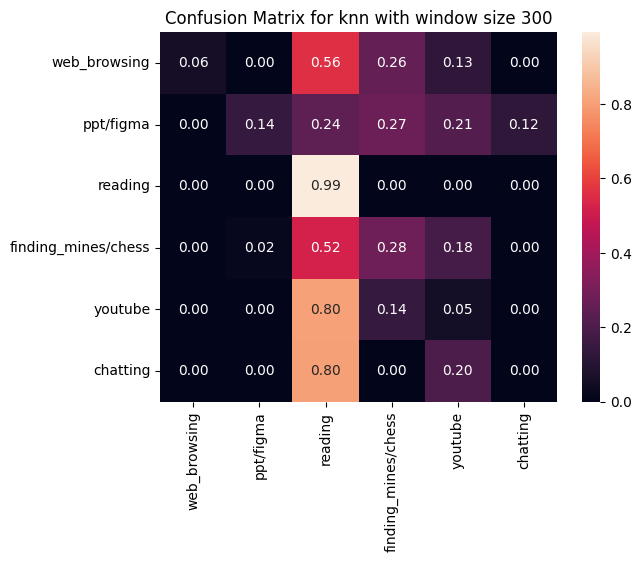

Model: knn, Window Size: 100, Accuracy: 0.29341424237015884, F1: 0.3011703142231184


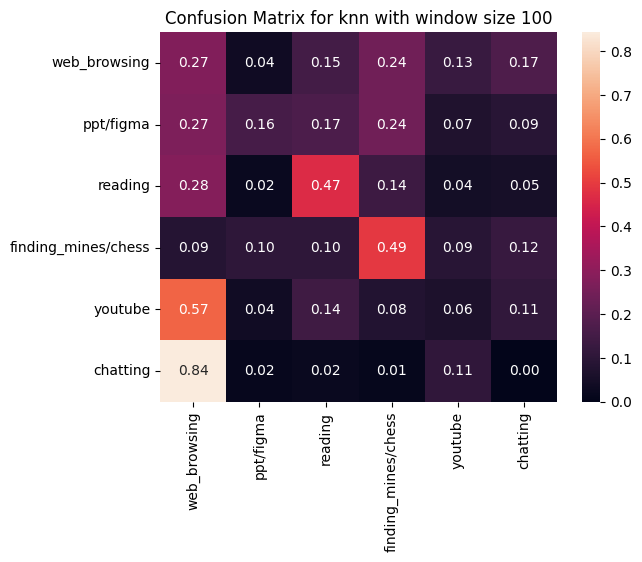

Model: knn, Window Size: 50, Accuracy: 0.3160740619367524, F1: 0.31824731656793687


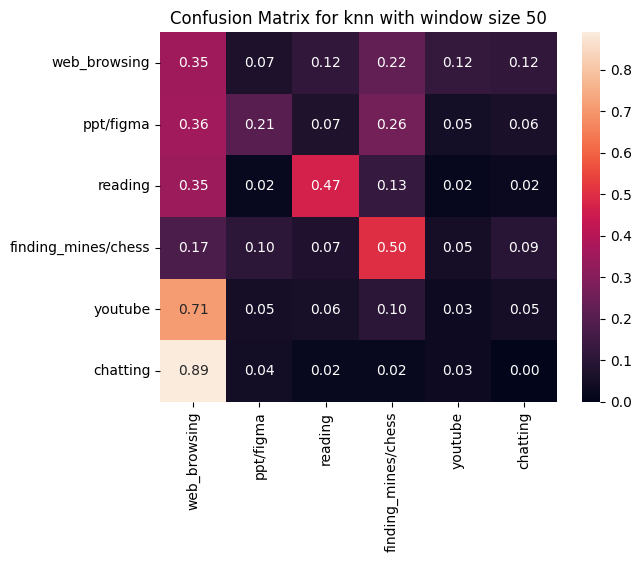

In [13]:
# Options: 'boosting', 'random_forest', 'svm', 'logistic_regression', 'poly_regression', 'knn'
for model_name in ['hist_boosting', 'random_forest', 'knn']: 
  for window_size in [300, 100, 50]:
    X, y, y_pred, model, scaler = train(model_name, window_size, window_interval, split=split)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    cm = confusion_matrix(y, y_pred, normalize='true')
    print(f"Model: {model_name}, Window Size: {window_size}, Accuracy: {acc}, F1: {f1}")
    # plot cm
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=category_names, yticklabels=category_names)
    plt.title(f"Confusion Matrix for {model_name} with window size {window_size}")
    plt.show()

## Train one model

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.023008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1574897
[LightGBM] [Info] Number of data points in the train set: 44934, number of used features: 7800
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
Model: lightgbm, Accuracy: 0.8506799888981404, F1: 0.8476320805061454


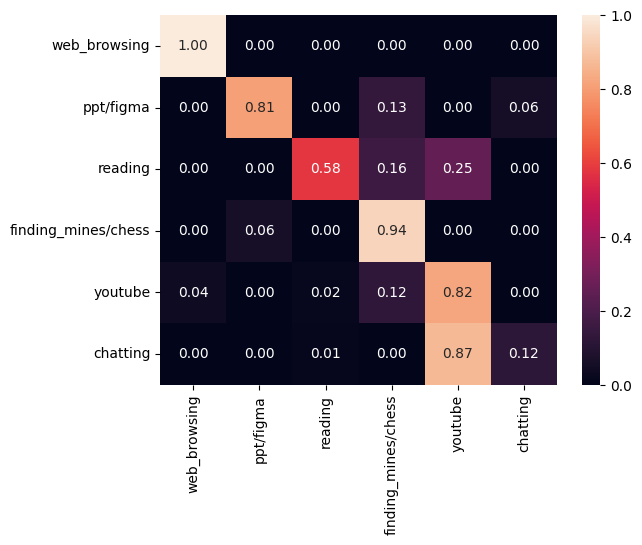

                Feature  Importance
4        0_click_y_mean          30
284     10_click_y_mean          27
60       2_click_y_mean          24
7366    263_num_scrolls          23
7982    285_num_scrolls          23
...                 ...         ...
1398  49_hold_time_mean           0
4922     175_pause_time           0
1397     49_pause_count           0
4924        175_flips_y           0
8399   299_hold_time_sd           0

[8400 rows x 2 columns]


In [15]:
model_name = "lightgbm"
window_size = 300
X, y, y_pred, model, scaler = train(model_name, window_size, 2, split=0.8)
acc = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred, average='weighted')
cm = confusion_matrix(y, y_pred, normalize='true')

print(f"Model: {model_name}, Accuracy: {acc}, F1: {f1}")
joblib.dump(model, f"{model_name}_model.pkl")
joblib.dump(scaler, f"{model_name}_scaler.pkl")
sns.heatmap(
    cm, annot=True, fmt=".2f", xticklabels=category_names, yticklabels=category_names
)
plt.show()
feature_names = [
    f"{i}_{feature}"
    for i in range(window_size)
    for feature in [
        "num_moves",
        "num_clicks",
        "num_scrolls",
        "click_x_mean",
        "click_y_mean",
        "movement_distance",
        "velocity_mean",
        "velocity_max",
        "velocity_min",
        "velocity_sd",
        "velocity_x_mean",
        "velocity_y_mean",
        "acceleration_mean",
        "acceleration_max",
        "acceleration_min",
        "acceleration_sd",
        "jerk_mean",
        "jerk_sd",
        "angular_velocity_mean",
        "angular_velocity_sd",
        "movement_duration",
        "total_time",
        "pause_time",
        "flips_x",
        "flips_y",
        "pause_count",
        "hold_time_mean",
        "hold_time_sd",
    ]
]

importance = model.feature_importances_
# Organize results into a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)
importance_df.to_csv(f"{model_name}_importance.csv", index=False)
print(importance_df)

## Unsupervised

In [13]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test, scaler = prepare_data(window_size, window_interval, resample=False, split=split)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")



X_train shape: (9740, 1400)
y_train shape: (9740,)


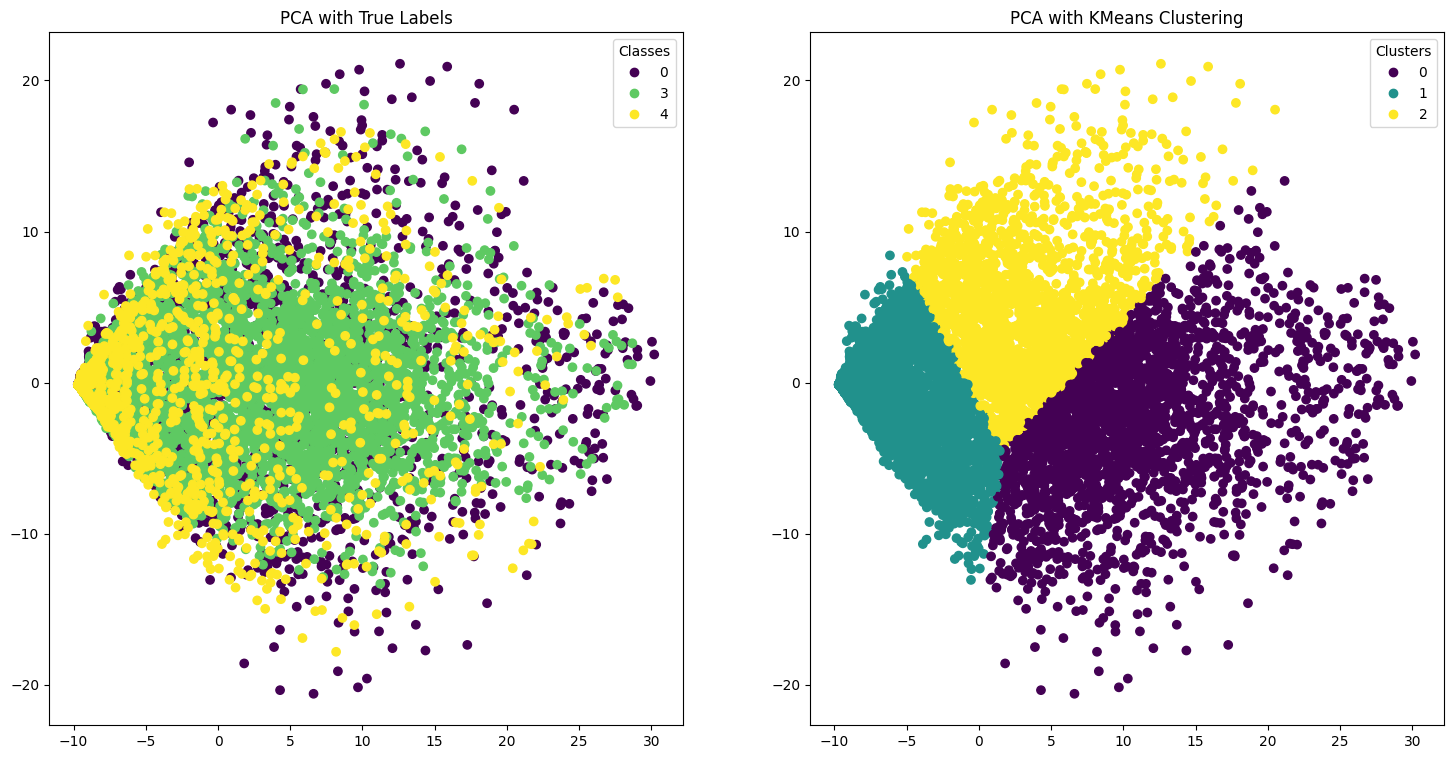

In [14]:
# perform PCA on the data
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust number of clusters if needed
kmeans_labels = kmeans.fit_predict(X_train_pca)

# Plot PCA results with true labels
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
plt.title("PCA with True Labels")
plt.legend(*scatter.legend_elements(), title="Classes")

# Plot PCA results with KMeans labels
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("PCA with KMeans Clustering")
plt.legend(*scatter.legend_elements(), title="Clusters")

plt.show()

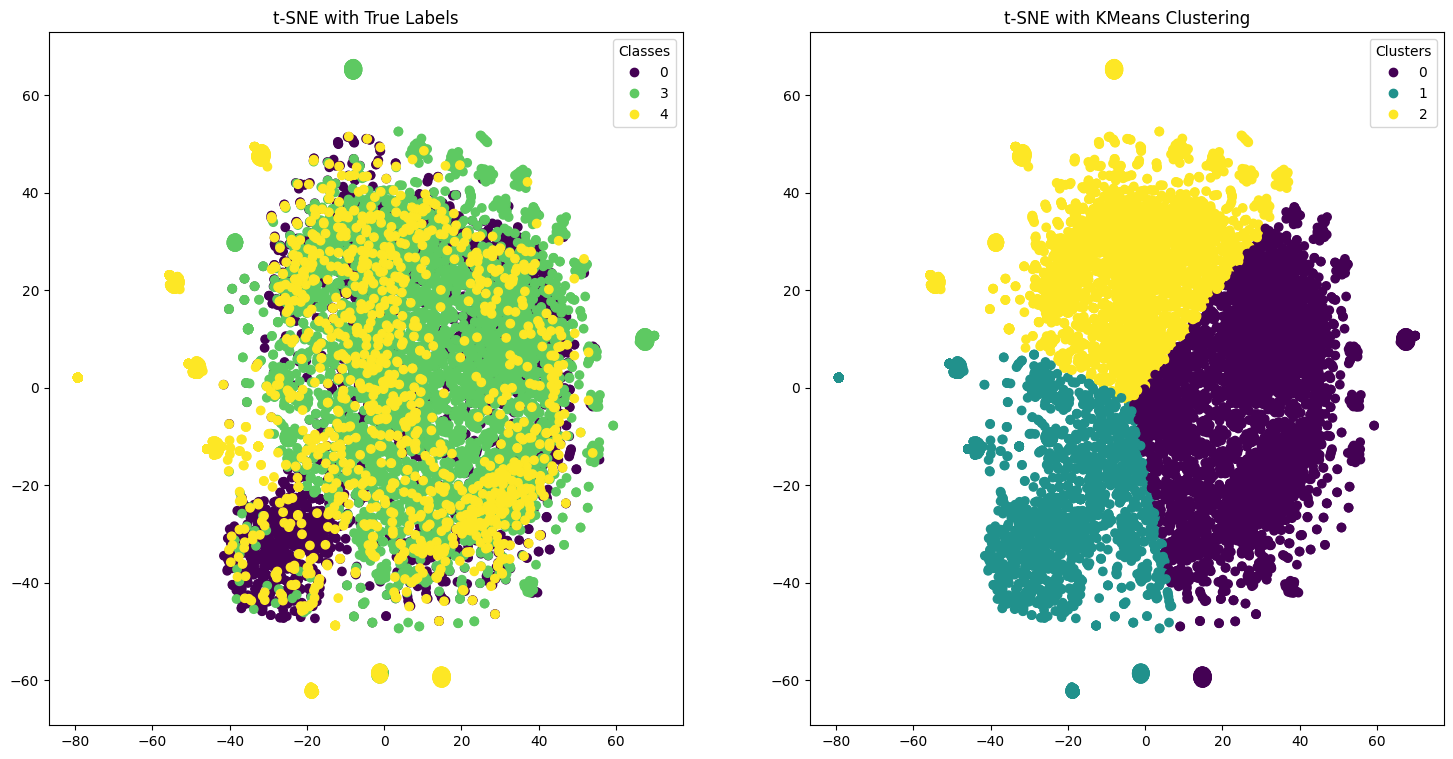

In [15]:
# Perform t-SNE on training data
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust number of clusters if needed
kmeans_labels = kmeans.fit_predict(X_train_tsne)

# Plot t-SNE results with true labels
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis')
plt.title("t-SNE with True Labels")
plt.legend(*scatter.legend_elements(), title="Classes")

# Plot t-SNE results with KMeans labels
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("t-SNE with KMeans Clustering")
plt.legend(*scatter.legend_elements(), title="Clusters")

plt.show()

## LSTM